In [13]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import os

# Set the environment variable to point to the license file on your Desktop
os.environ['GRB_LICENSE_FILE'] = os.path.expanduser('~/Desktop/gurobi.lic')


Loading data:

In [5]:
data = pd.read_csv('data_observed.csv')
data_observed = data[['X', 'Y', 'T', 'ips NN']]

          X  Y  T    ips NN
0  0.496714 -1  0  2.143429
1 -0.138264 -1  0  1.800368
2  0.647689 -1  0  2.235371
3  1.523030 -1  1  1.295515
4 -0.234153  1  0  1.731747


In [15]:
# Logistic function used for probability calculations
def logistic(z):
    """Helper logistic function."""
    return 1.0 / (1.0 + np.exp(-z))

# Main function to solve the Linear Program (LP)
def solve_my_lp(df_observed, policy, epsilon_0=0.1, epsilon_1=0.1, Gamma=2.0):


    # Initialize Gurobi model
    m = gp.Model("MyLP")
    m.setParam("OutputFlag", 0)  # Suppress solver output

    # Extract data from DataFrame
    X_vals = df_observed["X"].values
    T_vals = df_observed["T"].values
    Y_vals = df_observed["Y"].values
    hat_w  = df_observed["ips NN"].values
    n = len(df_observed)

    # Index sets
    I = range(n)
    I0 = [i for i in I if T_vals[i] == 0]  # Control group
    I1 = [i for i in I if T_vals[i] == 1]  # Treatment group



    # Distance function for constraints
    def d(i, j):
        return (X_vals[i] - X_vals[j]) ** 2

    eps = {0: epsilon_0, 1: epsilon_1}  # Epsilon values for constraints

    # Decision variables: w_i >= 0
    w_vars = m.addVars(n, lb=0, name="w")

    # Decision variables: zeta_{ij}^t >= 0
    zeta_vars = {}
    for t in [0, 1]:
        for i_ in I:
            for j_ in I:
                if (t == 0 and j_ in I0) or (t == 1 and j_ in I1):
                    zeta_vars[(t, i_, j_)] = m.addVar(lb=0.0, name=f"zeta_{t}_{i_}_{j_}")

    # Objective function
    obj_expr = gp.LinExpr()
    for i_ in I0:
        obj_expr.addTerms(policy[0,i_] * Y_vals[i_], w_vars[i_])
    for i_ in I1:
        obj_expr.addTerms(policy[1,i_] * Y_vals[i_], w_vars[i_])
    obj_expr = (1.0 / n) * obj_expr
    m.setObjective(obj_expr, GRB.MINIMIZE)


    # Distance constraints
    for t in [0, 1]:
        for j_ in I:
            if (t == 0 and j_ in I0) or (t == 1 and j_ in I1):
                m.addConstr(
                    gp.quicksum(d(i_, j_) * zeta_vars[(t, i_, j_)] for i_ in I) <= eps[t],
                    name=f"d_constraint_t{t}_j{j_}"
                )

    # Constraints for zeta sums
    for t in [0, 1]:
        for i_ in I:
            m.addConstr(
                gp.quicksum(zeta_vars[(t, i_, j_)] for j_ in (I0 if t == 0 else I1)) == 1.0 / n,
                name=f"zeta_sum_t{t}_i{i_}"
            )

    # Linking constraints between w and zeta
    for t in [0, 1]:
        for j_ in (I0 if t == 0 else I1):
          m.addConstr(
                w_vars[j_]/(sum(hat_w)) == gp.quicksum(zeta_vars[(t, i_, j_)] for i_ in I),
                name=f"w_link_{t}_j{j_}"
          )

    # Gamma-based constraints
    for i_ in I:
        m.addConstr(w_vars[i_] >= 1.0 + (1.0 / Gamma) * (hat_w[i_] - 1.0), name=f"Gamma_lower_{i_}")
        m.addConstr(w_vars[i_] <= 1.0 + Gamma * (hat_w[i_] - 1.0), name=f"Gamma_upper_{i_}")

    # Optimize the model
    m.optimize()



    # Retrieve results if the solution is optimal
    if m.status == GRB.OPTIMAL:
        obj_val = m.objVal
        #print(f"Optimal objective value = {obj_val:.4f}")

        # Retrieve w variables
        w_sol = np.array([w_vars[i_].X for i_ in I])
        #print("Optimal w:", w_sol)

        # Retrieve zeta variables
        zeta_sol = {}
        for t in [0, 1]:
            for i_ in I:
                for j_ in I:
                    if (t == 0 and j_ in I0) or (t == 1 and j_ in I1):
                        zeta_sol[(t, i_, j_)] = zeta_vars[(t, i_, j_)].X

        return {
            "objective_value": obj_val,
            "w": w_sol,
            "zeta": zeta_sol
        }
    else:
        print(f"Model ended with non-OPTIMAL status: {m.status}")
        return None



Solving the primal problem

Solving for Gamma = 1
Model ended with non-OPTIMAL status: 4
Solving for Gamma = 2
Model ended with non-OPTIMAL status: 4
Solving for Gamma = 3
Model ended with non-OPTIMAL status: 4


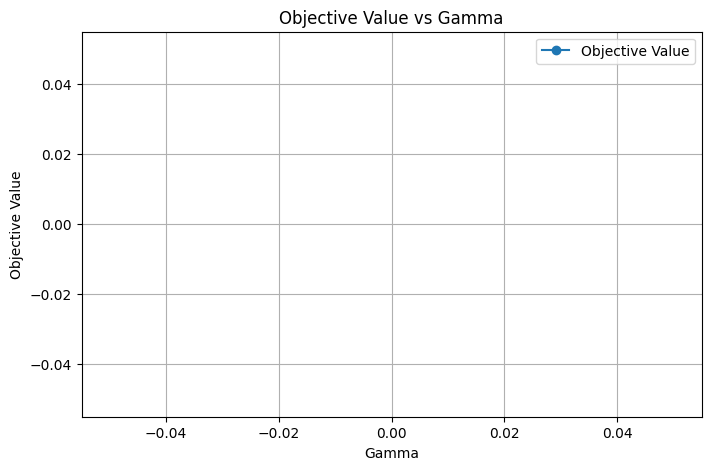

In [19]:
# Define the range of Gamma values (1 to 14)
Gamma_values = np.arange(1, 4)

# Define the sample policy (uniform 0.5 for all observations)
sample_policy = np.full((2, len(data_observed)), 0.5)

# Store objective values for each Gamma
objective_values = []

# Solve the optimization problem for each Gamma
for Gamma in Gamma_values:
    print(f"Solving for Gamma = {Gamma}")

    solution = solve_my_lp(
        data_observed,
        sample_policy,
        epsilon_0=0.1,
        epsilon_1=0.1,
        Gamma=Gamma,
    )

    # Extract the objective value if solution is valid, otherwise store NaN
    obj_val = solution.get("objective_value", np.nan) if solution else np.nan
    objective_values.append(obj_val)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(Gamma_values, objective_values, marker='o', linestyle='-', label="Objective Value")

plt.xlabel('Gamma')
plt.ylabel('Objective Value')
plt.title('Objective Value vs Gamma')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
objective_values.to_csv('objective_values_primal.csv', index=False)

AttributeError: 'list' object has no attribute 'to_csv'